In [1]:
from sigvisa.treegp.gp import GP, GPCov, prior_sample, mcov

X = np.array(((-2.0, 0.0,), (-1.0, 0.0), (0.0, 0.0), (1.0, 0.0), (2.0, 0.0)))
Xorig = X.copy()
cov = GPCov(wfn_params=(1.0,), wfn_str="se", dfn_params=(2.0, 2.0), dfn_str="euclidean")


In [2]:
n = X.shape[0]
n_samples = 20
y = np.zeros((n_samples, n))
for i in range(n_samples):
    y[i,:] = prior_sample(X, cov, 0.01)

In [161]:
import scipy.stats
_, K = prior_sample(X, cov, 0.01, return_K=True)

def llX(X, y):
    n_samples = y.shape[0]
    ll = 0.0
    
    for i in range(n_samples):
        #ll += scipy.stats.multivariate_normal(mean=np.zeros((n,)), cov=K).logpdf(y[i,:])
        gp = GP(X, y[i,:], cov_main=cov, noise_var=0.01, compute_ll=True, sparse_invert=False)
        ll += gp.log_likelihood()
    return ll

def wishart_lp(dof, scale, mat):
    d = scale.shape[0]
    n = dof
    
    invScale = np.linalg.inv(scale)
    
    s, logdet = numpy.linalg.slogdet(mat)
    val = 0.5*(n-1-d)*logdet
    val += -0.5 * numpy.trace(numpy.dot(mat,invScale))

    norm  = -0.5*dof*d * np.log(2.0)
    norm += -0.5*dof * numpy.linalg.slogdet(scale)[1]
    norm += -0.25*d*(d-1)*np.log(np.pi)
    for i in xrange(d):
        norm -= np.log(scipy.special.gamma(0.5*(n-i)))
    return norm+val
        
def llXWishart(X, y):
    K = mcov(X, cov, 0.01)
    S = np.dot(y.T, y)
    ll = wishart_lp(n_samples, K, S)
    return ll

#X2 = np.array(((-2.0, 0.0,), (-1.0, 0.0), (0.0, 0.0), (1.0, 0.0), (2.0, 0.0)))
#llXWishart(X2, y)

In [34]:
def mh_step_pt(X, y, i, lp_old, std=0.5, f_ll=llX):
    Xnew = X.copy()
    Xnew[i,:] += np.random.randn(2)*std
    lp_new = f_ll(Xnew, y)
    
    log_u = np.log(np.random.rand())
    if lp_new - lp_old > log_u:
        return Xnew, lp_new, True
    else:
        return X, lp_old, False
    
def run_mcmc(Xinit, y, steps=200, f_ll=llX, std=0.5):
    n = Xinit.shape[0]
    X = Xinit.copy()
    lp = f_ll(X, y)
    accepteds = []
    Xs = []
    lps = []
    for step in range(steps):
        for i in range(n):
            X, lp, accepted = mh_step_pt(X, y, i, lp, f_ll=f_ll, std=std)
            accepteds.append(accepted)
        Xs.append(X)
        lps.append(lp)
        if step % 10 == 9:
            print "step", step, "lp", lp, "acceptance rate", np.mean(accepteds)
            
    return Xs, lps

In [34]:
Xs, lps = run_mcmc(np.zeros(X.shape))

step 9 lp -108.778433257 acceptance rate 0.4
step 19 lp -102.197213184 acceptance rate 0.39
step 29 lp -96.8680951311 acceptance rate 0.306666666667
step 39 lp -96.4626663389 acceptance rate 0.29
step 49 lp -101.065798995 acceptance rate 0.288
step 59 lp -105.065833562 acceptance rate 0.26
step 69 lp -99.5631643151 acceptance rate 0.248571428571
step 79 lp -99.6385924996 acceptance rate 0.235
step 89 lp -99.4879131278 acceptance rate 0.226666666667
step 99 lp -99.097201527 acceptance rate 0.218
step 109 lp -96.5427500441 acceptance rate 0.22
step 119 lp -98.7305644096 acceptance rate 0.211666666667
step 129 lp -94.9297461452 acceptance rate 0.2
step 139 lp -97.8912245312 acceptance rate 0.195714285714
step 149 lp -95.9746450016 acceptance rate 0.193333333333
step 159 lp -98.8463607914 acceptance rate 0.19125
step 169 lp -96.9408124776 acceptance rate 0.187058823529
step 179 lp -97.4063235963 acceptance rate 0.184444444444
step 189 lp -95.702755845 acceptance rate 0.178947368421
step 19

In [37]:
Xsw, lpsw = run_mcmc(np.random.randn(X.size).reshape(X.shape), f_ll=llXWishart, steps=500)

step 9 lp -62.5104373986 acceptance rate 0.58
step 19 lp -57.4275269199 acceptance rate 0.62
step 29 lp -58.5791055298 acceptance rate 0.6
step 39 lp -58.3282181071 acceptance rate 0.58
step 49 lp -60.0729586909 acceptance rate 0.576
step 59 lp -59.251813097 acceptance rate 0.576666666667
step 69 lp -55.1067485885 acceptance rate 0.574285714286
step 79 lp -56.0838052113 acceptance rate 0.5625
step 89 lp -57.6661328061 acceptance rate 0.56
step 99 lp -54.8169476048 acceptance rate 0.558
step 109 lp -61.6216154349 acceptance rate 0.556363636364
step 119 lp -55.816586366 acceptance rate 0.555
step 129 lp -61.1822689221 acceptance rate 0.553846153846
step 139 lp -56.9872440576 acceptance rate 0.551428571429
step 149 lp -55.2004514098 acceptance rate 0.557333333333
step 159 lp -59.3947165302 acceptance rate 0.5575
step 169 lp -57.9513696811 acceptance rate 0.56
step 179 lp -56.1625580361 acceptance rate 0.565555555556
step 189 lp -57.9356257351 acceptance rate 0.562105263158
step 199 lp -54

/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log


NameError: name 'Xs' is not defined

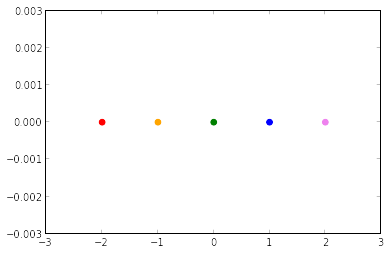

In [11]:
def visX(X, alpha=0.5):
    colors = ('red', 'orange', 'green', 'blue', 'violet')
    colors2 = ('red', 'pink', 'orange', 'yellow', 'green', 'teal', 'blue', 'violet', 'brown', 'black')
    if X.shape[0] > len(colors):
        cc = colors2
    else:
        cc = colors
    for i in range(X.shape[0]):
        scatter(X[i:i+1,0], X[i:i+1,1], c=cc[i], linewidth=0, s=50, alpha=alpha)

visX(Xorig, alpha=1.0)
figure()
for X in Xs:
    visX(X)
    
figure()
for X in Xs[20:80:5]:
    visX(X)
figure()
for X in Xs[80:160:5]:
    visX(X)
figure()
for X in Xs[160:200:5]:
    visX(X)

In [55]:
llX(Xgrid, y)

-286.34821628662854

In [19]:
Xgrid = np.array([(np.cos(x), np.sin(x)) for x in np.linspace(0, 2*np.pi, 9)][:8])
X = Xgrid
n = X.shape[0]
n_samples = 25
y = np.zeros((n_samples, n))
for i in range(n_samples):
    y[i,:] = prior_sample(X, cov, 0.01)
    

#Xs_grid, lps_grid = run_mcmc(Xgrid, y, steps=10)

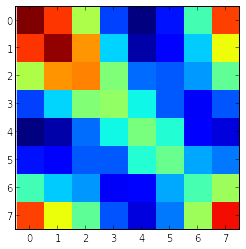

In [38]:
# NEXT TO TRY:
# why am I not successfully recovering a grid structure?
# what if we don't know the GP? can we include the GP hyperparm in the model?

cc = np.dot(y.T, y)/n_samples
# est_distances = 


[[  1.00000000e+00   0.00000000e+00]
 [  7.07106781e-01   7.07106781e-01]
 [  6.12323400e-17   1.00000000e+00]
 [ -7.07106781e-01   7.07106781e-01]
 [ -1.00000000e+00   1.22464680e-16]
 [ -7.07106781e-01  -7.07106781e-01]
 [ -1.83697020e-16  -1.00000000e+00]
 [  7.07106781e-01  -7.07106781e-01]]
step 9 lp -192.207400708 acceptance rate 0.6375
step 19 lp -177.096905535 acceptance rate 0.55625
step 9 lp -251.528326333 acceptance rate 0.4625
step 19 lp -200.824157085 acceptance rate 0.43125
step 9 lp -232.627848164 acceptance rate 0.6
step 19 lp -201.996224308 acceptance rate 0.575
step 9 lp -273.017639104 acceptance rate 0.4875
step 19 lp -200.414590917 acceptance rate 0.51875
step 9 lp -237.182399408 acceptance rate 0.4875
step 19 lp -214.711755657 acceptance rate 0.5
step 9 lp -210.851450585 acceptance rate 0.65
step 19 lp -195.02536787 acceptance rate 0.5875
step 9 lp -234.532655883 acceptance rate 0.5125
step 19 lp -224.097760686 acceptance rate 0.525
step 9 lp -207.198160204 accepta

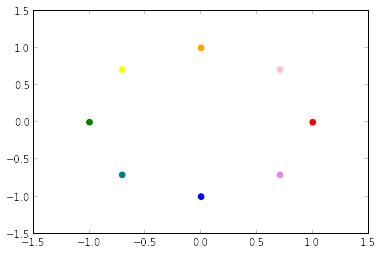

In [36]:
print Xgrid
visX(Xgrid, alpha=1.0)


rrXs = []
rrlps = []
for i in range(20):
    Xinit = np.random.randn(Xgrid.size).reshape(Xgrid.shape)
    Xs_grid, lps_grid = run_mcmc(Xinit, y, steps=20, std=0.2)
    rrlps.append( lps_grid[-1])
    rrXs.append(Xs_grid[-1])
best_idx = np.argmax(rrlps)

print "running for real with X", rrXs[best_idx], "lp", rrlps[best_idx]
Xs_grid, lps_grid = run_mcmc(rrXs[best_idx], y, steps=200, std=0.2)

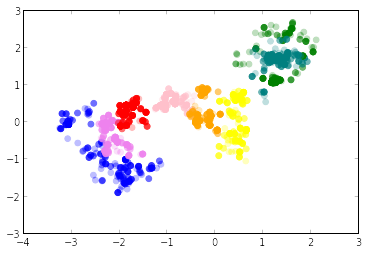

In [37]:
figure()
for X in Xs_grid:
    visX(X)

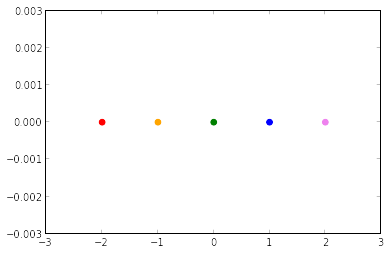

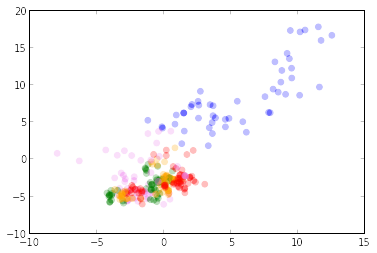

In [38]:
def visX(X, alpha=0.5):
    colors = ('red', 'orange', 'green', 'blue', 'violet')
    for i in range(X.shape[0]):
        scatter(X[i:i+1,0], X[i:i+1,1], c=colors[i], linewidth=0, s=50, alpha=alpha)

visX(Xorig, alpha=1.0)
figure()
for X in Xsw[::10]:
    visX(X)


# Inferring distances: empirical cov as Wishart sufficient statistic


In [115]:
X = np.array(((0.0,0.0), (1.0, 0.0)))
K = mcov(X, cov, 0.01)
n_samples = 25
n = X.shape[0]
y = np.zeros((n_samples, n))
for i in range(n_samples):
    y[i,:] = prior_sample(X, cov, 0.01)

S = np.dot(y.T, y)



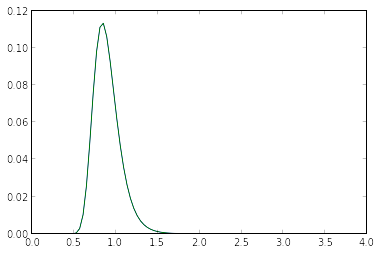

In [116]:
ds = np.linspace(0.0, 4.0, 100)
Ks = [mcov(np.array(((0.0,0.0), (d, 0.0))), cov, 0.01) for d in ds]
lpds = [wishart_lp(n_samples, K, S) for K in Ks] # p(S|D)
lpds_g = [np.sum([scipy.stats.multivariate_normal(mean=np.zeros((2,)), cov=K).logpdf(y[i,:]) for i in range(n_samples)]) for K in Ks]

p1 = np.exp(lpds)
p1 /= np.sum(p1)

p2 = np.exp(lpds_g)
p2 /= np.sum(p2)

plot(ds, p1)
plot(ds, p2)

# Distance point estimates for classic MDS

In [188]:

def d_to_D(d):
    n = int((1 + np.sqrt(1+8*len(d)))/2)
    D = np.zeros((n,n))
    idx = 0
    for i in range(n):
        l = n-i-1
        D[i, i+1:n] = d[idx:idx+l]
        D[i+1:n, i] = d[idx:idx+l]
        idx += l
    return D

def D_to_d(D):
    nd = (n**2-n)/2
    d = np.zeros((nd,))
    idx = 0
    for i in range(n):
        l = n-i-1
        d[idx:idx+l] = D[i, i+1:n]
        d[idx:idx+l] = D[i+1:n, i]
        idx += l
    return d

def D_to_K(D):
    return np.exp(-.5*D**2/2.0) + np.eye(D.shape[0])*0.01

def d_to_K(d):
    return D_to_K(d_to_D(d))

In [189]:
#def estimate_d(y):
#    n_samples, n = y.shape
#    S = np.dot(y.T, y)
#    init_d = D_to_d(init_D(S, n, n_samples))
#    nlp = lambda d : -wishart_lp(n_samples, d_to_K(d), S)
#    r = scipy.optimize.minimize(nlp, init_d)
#    print r
#    return r.x

def d_marginal(S, n_samples, i, j):
    S2 = np.array(((S[i,i], S[i,j]), (S[j,i], S[j,j])))
    nlp = lambda d : -wishart_lp(n_samples, d_to_K(d), S2)
    r = scipy.optimize.minimize(nlp, (0.5,), bounds=((0.0, 5.0),))
    return r.x

def init_D(S, n, n_samples):
    D = np.zeros(S.shape)
    for i in range(n):
        for j in range(i+1, n):
            D[i,j] = d_marginal(S, n_samples, i, j)
            D[j,i] = D[i,j]
    return D

In [199]:
S = np.dot(y.T, y)

D0 = init_D(S, n, n_samples)


In [200]:
Xcircle = np.array([(np.cos(x), np.sin(x)) for x in np.linspace(0, 2*np.pi, 9)][:8])
X = Xcircle
n = X.shape[0]
n_samples = 25
y = np.zeros((n_samples, n))
for i in range(n_samples):
    y[i,:] = prior_sample(X, cov, 0.01)

S = np.dot(y.T, y)
Dhat = init_D(S, n, n_samples)

In [205]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
Xhat = mds.fit(Dhat).embedding_

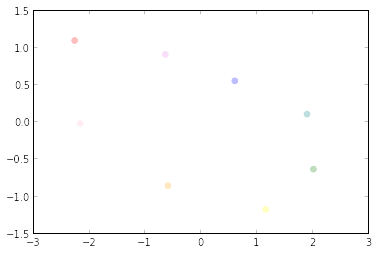

In [206]:
visX(Xhat)

In [207]:
Xs_grid, lps_grid = run_mcmc(Xhat, y, steps=200, std=0.2)

step 9 lp -165.032656436 acceptance rate 0.525
step 19 lp -141.1508281 acceptance rate 0.46875
step 29 lp -125.798998573 acceptance rate 0.408333333333
step 39 lp -125.380155978 acceptance rate 0.353125
step 49 lp -119.727176248 acceptance rate 0.3225
step 59 lp -114.550504292 acceptance rate 0.297916666667
step 69 lp -117.563837846 acceptance rate 0.269642857143
step 79 lp -118.011024192 acceptance rate 0.2546875
step 89 lp -117.688997606 acceptance rate 0.244444444444
step 99 lp -121.184859037 acceptance rate 0.2375
step 109 lp -118.226149856 acceptance rate 0.239772727273
step 119 lp -117.630597739 acceptance rate 0.232291666667
step 129 lp -118.753583396 acceptance rate 0.226923076923
step 139 lp -120.039886889 acceptance rate 0.225
step 149 lp -115.982917891 acceptance rate 0.223333333333
step 159 lp -117.878978107 acceptance rate 0.21953125
step 169 lp -117.426342087 acceptance rate 0.222058823529
step 179 lp -114.421282675 acceptance rate 0.222916666667
step 189 lp -118.12271473

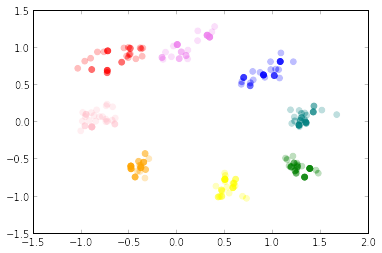

In [209]:
figure()
for X in Xs_grid[50::5]:
    visX(X)